In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np


E:\CS7GV1\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_generator(input_layer, condition_layer):

  merged_input = Concatenate()([input_layer, condition_layer])
  
  hid = Dense(128 * 8 * 8, activation='relu')(merged_input)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((8, 8, 128))(hid)

  hid = Conv2D(128, kernel_size=4, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)
  model.summary()
  
  return model, out


In [3]:
def get_discriminator(input_layer, condition_layer):
  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Flatten()(hid)
  
  merged_layer = Concatenate()([hid, condition_layer])
  hid = Dense(512, activation='relu')(merged_layer)
  #hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)

  model.summary()

  return model, out

In [4]:
from keras.preprocessing import image

def one_hot_encode(y):
  z = np.zeros((len(y), 10))
  idx = np.arange(len(y))
  z[idx, y] = 1
  return z

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def generate_random_labels(n):
  y = np.random.choice(10, n)
  y = one_hot_encode(y)
  return y

tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
  
def show_samples(batchidx):
  fig, axs = plt.subplots(5, 6, figsize=(10,6))
  plt.subplots_adjust(hspace=0.3, wspace=0.1)
  #fig, axs = plt.subplots(5, 6)
  #fig.tight_layout()
  for classlabel in range(10):
    row = int(classlabel / 2)
    coloffset = (classlabel % 2) * 3
    lbls = one_hot_encode([classlabel] * 3)
    noise = generate_noise(3, 100)
    gen_imgs = generator.predict([noise, lbls])

    for i in range(3):
        # Dont scale the images back, let keras handle it
        img = image.array_to_img(gen_imgs[i], scale=True)
        axs[row,i+coloffset].imshow(img)
        axs[row,i+coloffset].axis('off')
        if i ==1:
          axs[row,i+coloffset].set_title(tags[classlabel])
  plt.show()
  plt.close()  

In [5]:
# GAN creation
img_input = Input(shape=(32,32,3))
disc_condition_input = Input(shape=(10,))

discriminator, disc_out = get_discriminator(img_input, disc_condition_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
gen_condition_input = Input(shape=(10,))
generator, gen_out = get_generator(noise_input, gen_condition_input)

gan_input = Input(shape=(100,))
x = generator([gan_input, gen_condition_input])
gan_out = discriminator([x, disc_condition_input])
gan = Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 128)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 32, 3)    2970755     input_5[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________

E:\CS7GV1\envs\py35\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`


In [6]:
BATCH_SIZE = 32

# # Get training images
(X_train, y_train), (X_test, _) = cifar10.load_data()

# Normalize data
X_train = (X_train - 127.5) / 127.5

# 1hot encode labels
y_train = one_hot_encode(y_train[:,0])

print ("Training shape: {}".format(X_train.shape))
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

Training shape: (50000, 32, 32, 3)


In [7]:
# Array to store samples for experience replay
exp_replay = []

E:\CS7GV1\envs\py35\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


	Epoch: 1, Generator Loss: 0.016193895582849022, Discriminator Loss: [0.01041194 0.        ]


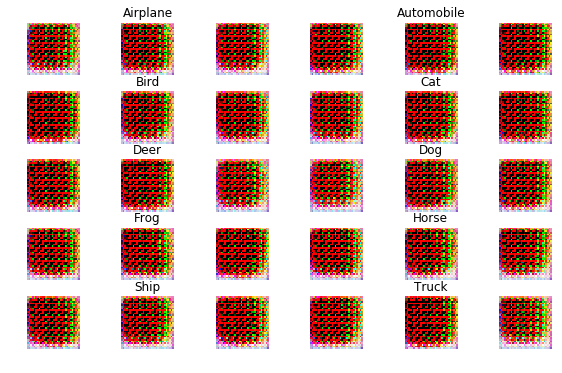

	Epoch: 2, Generator Loss: 0.01604679945937421, Discriminator Loss: [0.00752053 0.        ]


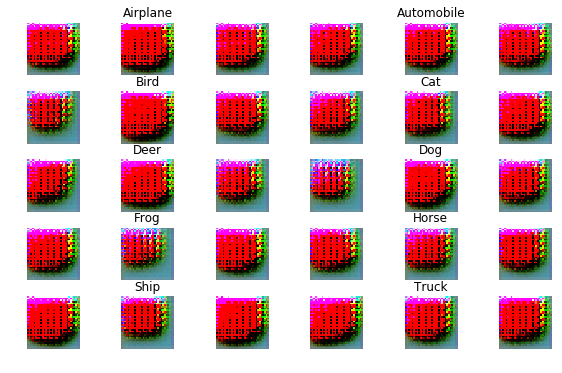

	Epoch: 3, Generator Loss: 0.018768575934457108, Discriminator Loss: [0.00764778 0.        ]


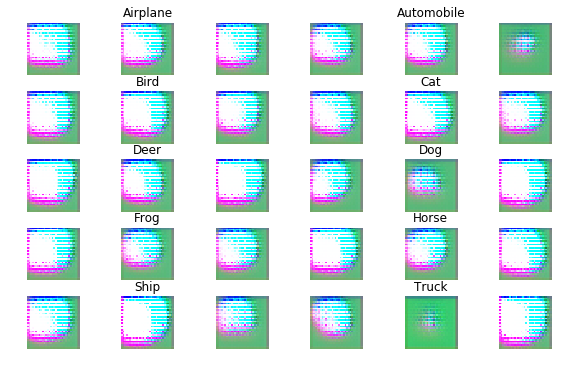

	Epoch: 4, Generator Loss: 0.0354233105570345, Discriminator Loss: [0.00765453 0.        ]


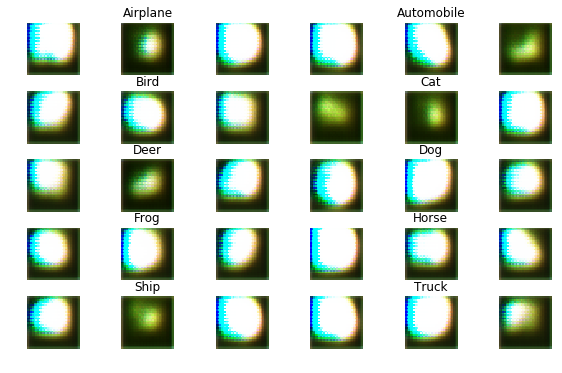

	Epoch: 5, Generator Loss: 0.036551491170167615, Discriminator Loss: [0.00665656 0.        ]


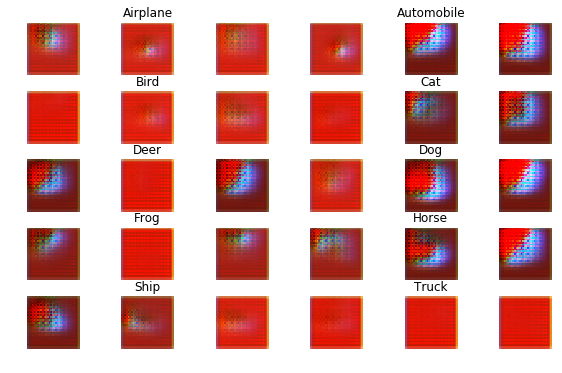

	Epoch: 6, Generator Loss: 0.009349840646669287, Discriminator Loss: [0.00675205 0.        ]


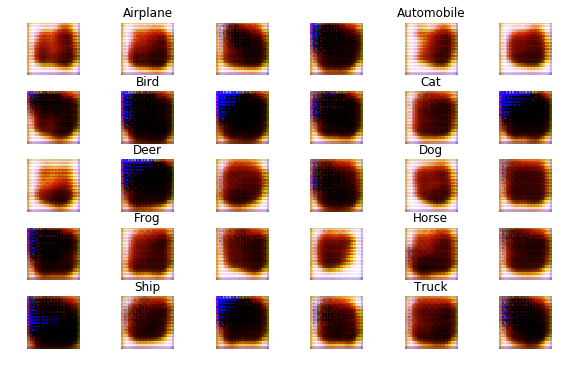

	Epoch: 7, Generator Loss: 0.021533728041775554, Discriminator Loss: [0.00817223 0.        ]


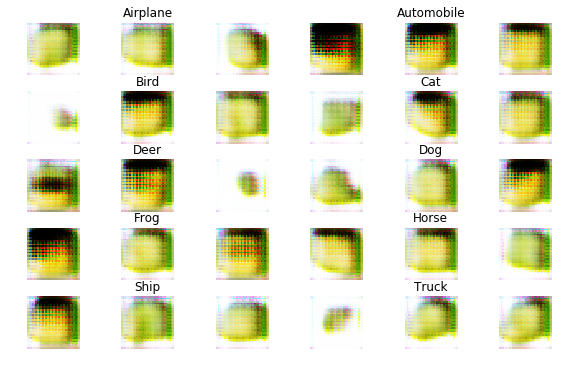

	Epoch: 8, Generator Loss: 0.03822078255318802, Discriminator Loss: [0.00801403 0.        ]


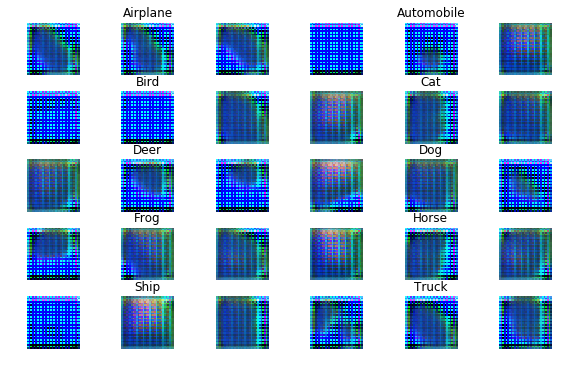

	Epoch: 9, Generator Loss: 0.024205118885189867, Discriminator Loss: [0.00803106 0.        ]


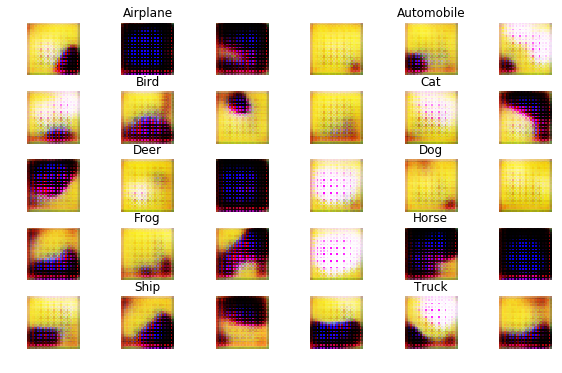

	Epoch: 10, Generator Loss: 0.030996113290554735, Discriminator Loss: [0.00859589 0.        ]


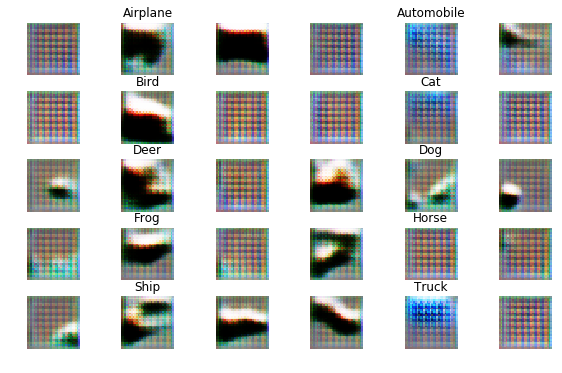

	Epoch: 11, Generator Loss: 0.012314670140856207, Discriminator Loss: [0.00777547 0.        ]


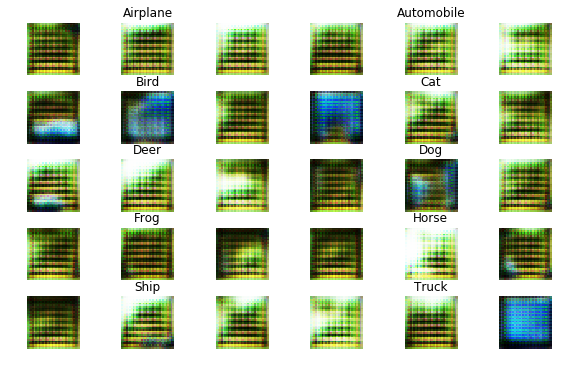

	Epoch: 12, Generator Loss: 0.027252777838523805, Discriminator Loss: [0.00721294 0.        ]


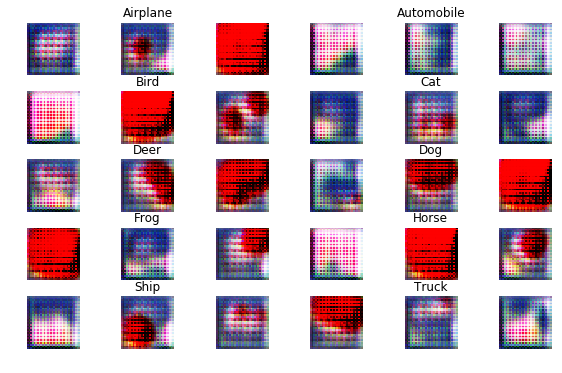

	Epoch: 13, Generator Loss: 0.03870725986594275, Discriminator Loss: [0.00851914 0.        ]


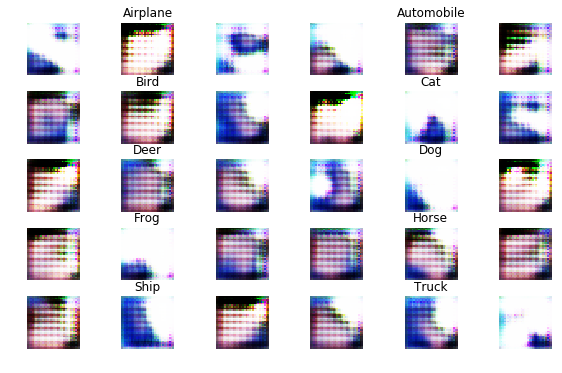

	Epoch: 14, Generator Loss: 0.01843916246531562, Discriminator Loss: [0.00696664 0.        ]


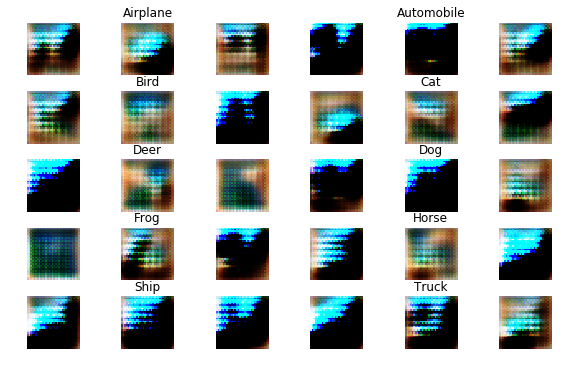

	Epoch: 15, Generator Loss: 0.023236285728162748, Discriminator Loss: [0.00772359 0.        ]


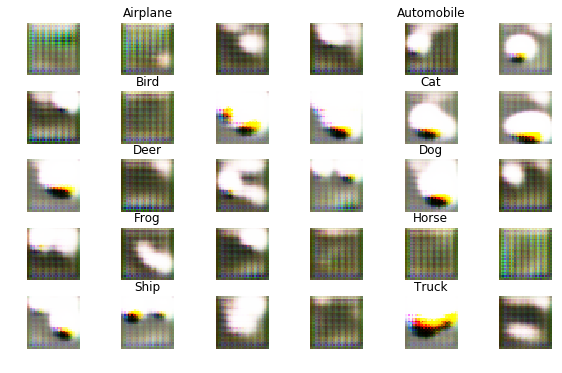

	Epoch: 16, Generator Loss: 0.02512814449897649, Discriminator Loss: [0.00735846 0.        ]


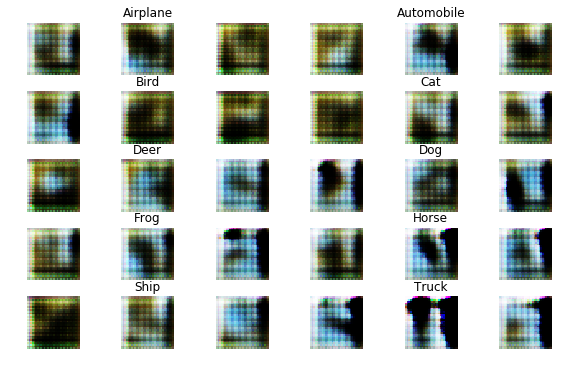

	Epoch: 17, Generator Loss: 0.033643511590212775, Discriminator Loss: [0.0078823 0.       ]


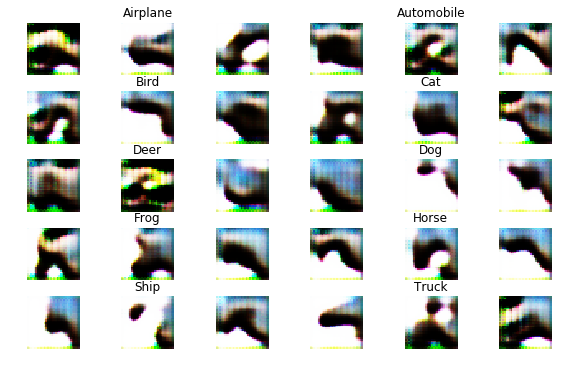

	Epoch: 18, Generator Loss: 0.025792910160542144, Discriminator Loss: [0.00746818 0.        ]


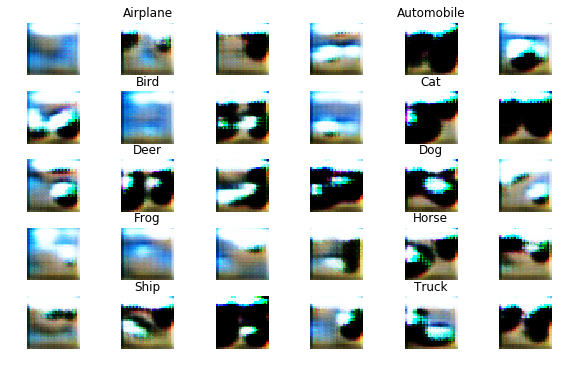

	Epoch: 19, Generator Loss: 0.01636303847753437, Discriminator Loss: [0.00732792 0.        ]


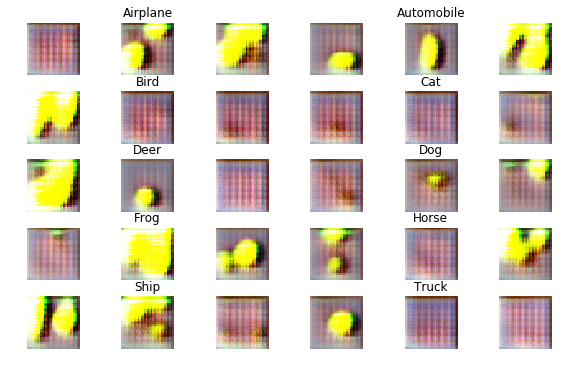

	Epoch: 20, Generator Loss: 0.027093866780381195, Discriminator Loss: [0.00727988 0.        ]


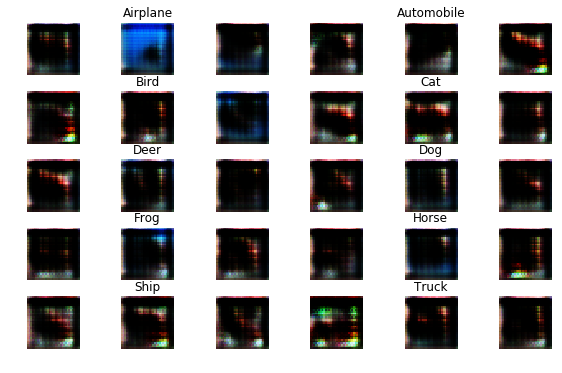

	Epoch: 21, Generator Loss: 0.02232409229504467, Discriminator Loss: [0.00736969 0.        ]


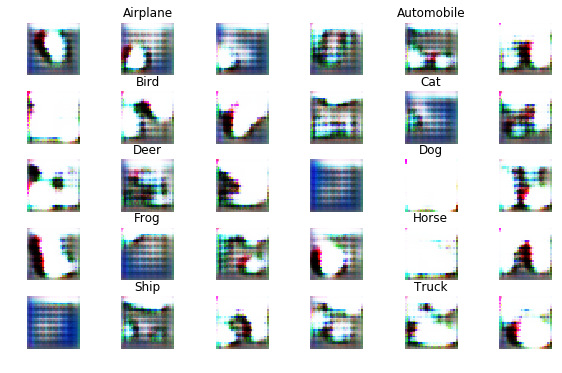

	Epoch: 22, Generator Loss: 0.031476105259261575, Discriminator Loss: [0.00759703 0.        ]


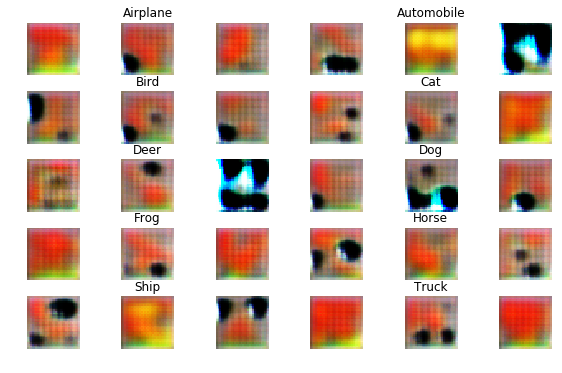

	Epoch: 23, Generator Loss: 0.023697450337275654, Discriminator Loss: [0.00687763 0.        ]


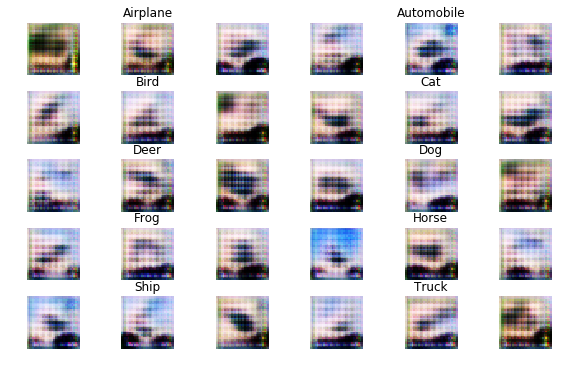

	Epoch: 24, Generator Loss: 0.011170479098141728, Discriminator Loss: [0.00632829 0.        ]


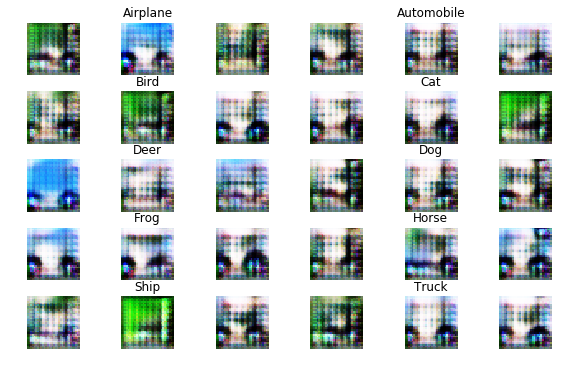

	Epoch: 25, Generator Loss: 0.03363103246872007, Discriminator Loss: [0.00747609 0.        ]


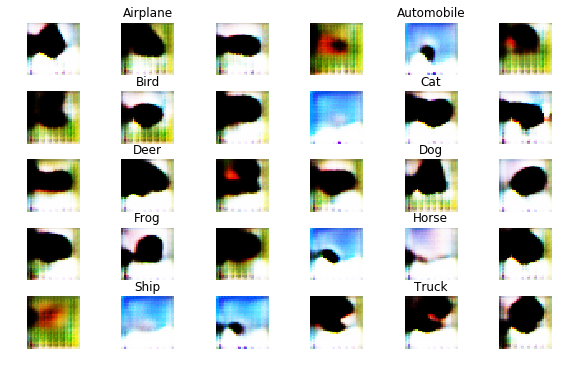

	Epoch: 26, Generator Loss: 0.02322185502200365, Discriminator Loss: [0.0072544 0.       ]


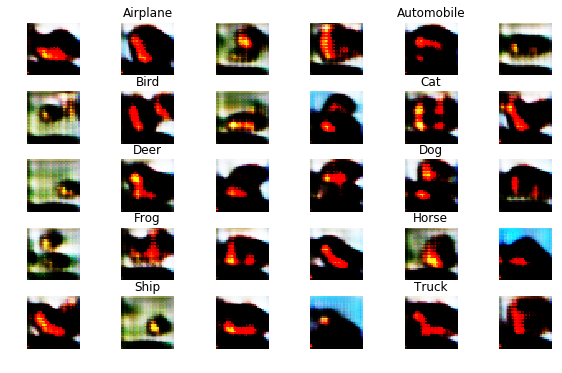

	Epoch: 27, Generator Loss: 0.01618891731429268, Discriminator Loss: [0.00727318 0.        ]


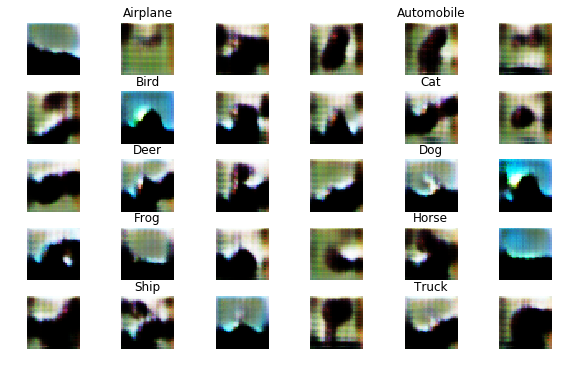

	Epoch: 28, Generator Loss: 0.02514993964137555, Discriminator Loss: [0.00847562 0.        ]


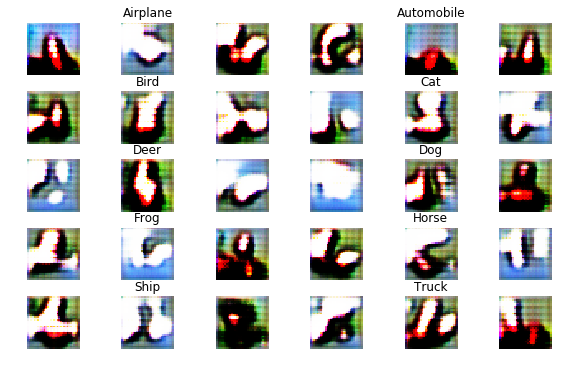

	Epoch: 29, Generator Loss: 0.03255942557364817, Discriminator Loss: [0.00808234 0.        ]


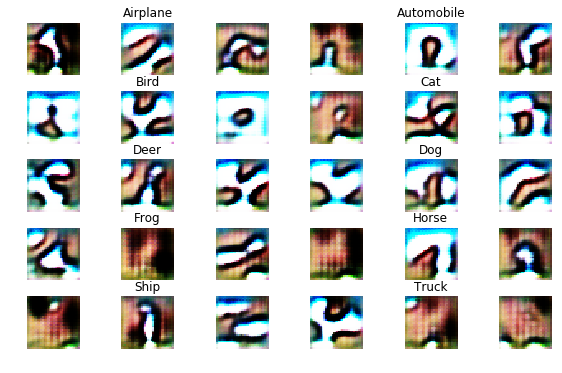

	Epoch: 30, Generator Loss: 0.02632959429341608, Discriminator Loss: [0.00753095 0.        ]


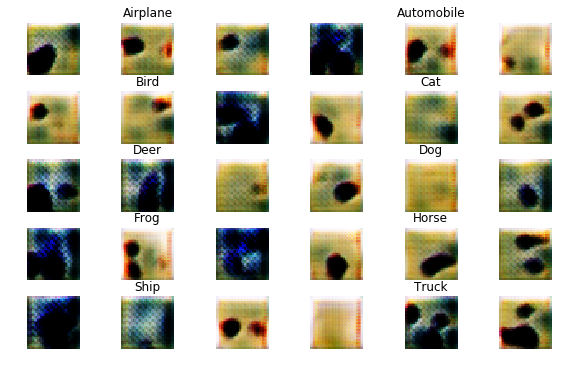

	Epoch: 31, Generator Loss: 0.032725870342169165, Discriminator Loss: [0.00860966 0.        ]


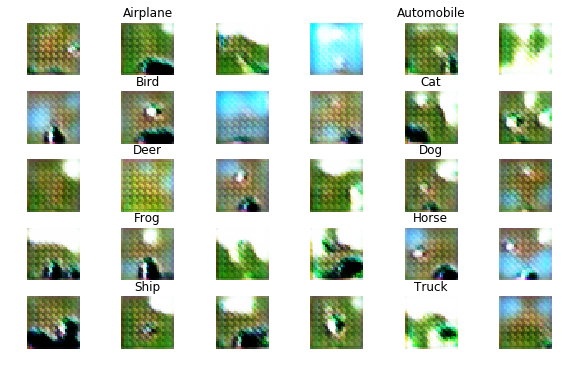

	Epoch: 32, Generator Loss: 0.024416357603176914, Discriminator Loss: [0.00872959 0.        ]


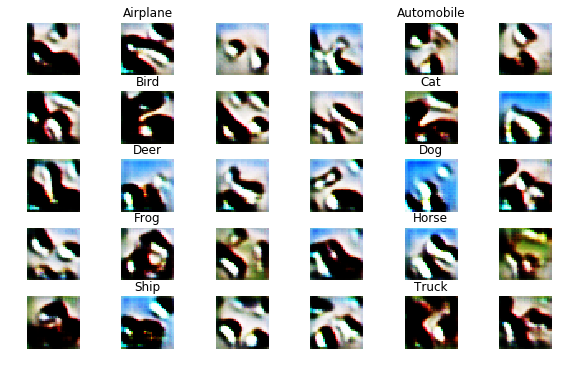

	Epoch: 33, Generator Loss: 0.013515185140235477, Discriminator Loss: [0.00701827 0.        ]


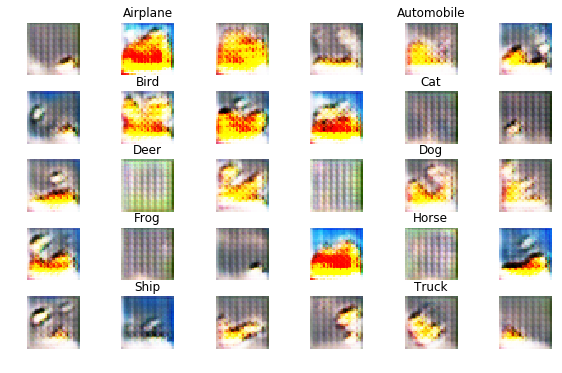

	Epoch: 34, Generator Loss: 0.0215955544143877, Discriminator Loss: [0.00808778 0.        ]


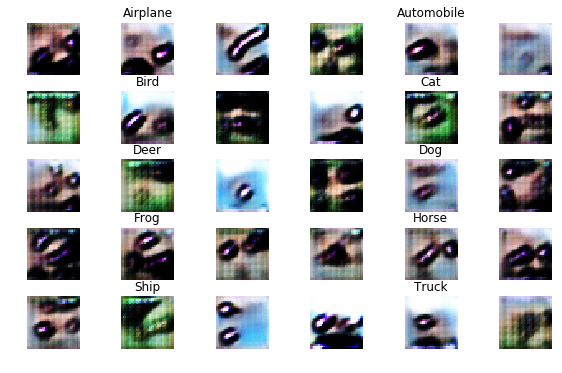

	Epoch: 35, Generator Loss: 0.024724952122923964, Discriminator Loss: [0.00792373 0.        ]


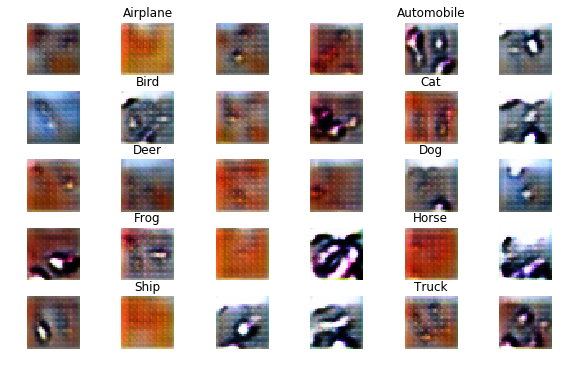

	Epoch: 36, Generator Loss: 0.019720899348985525, Discriminator Loss: [0.0087436 0.       ]


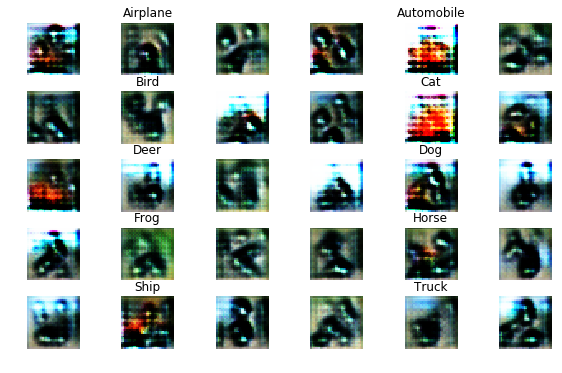

	Epoch: 37, Generator Loss: 0.01773494171043059, Discriminator Loss: [0.00775196 0.        ]


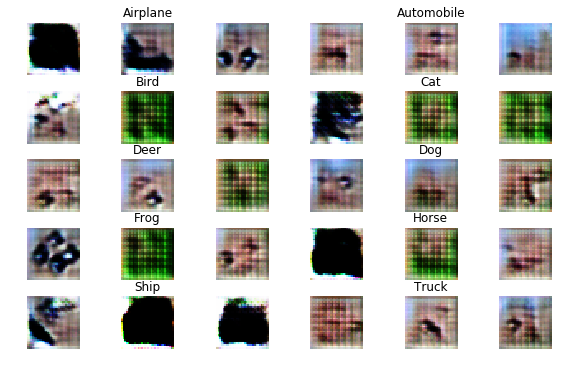

	Epoch: 38, Generator Loss: 0.020644481199651614, Discriminator Loss: [0.00801014 0.        ]


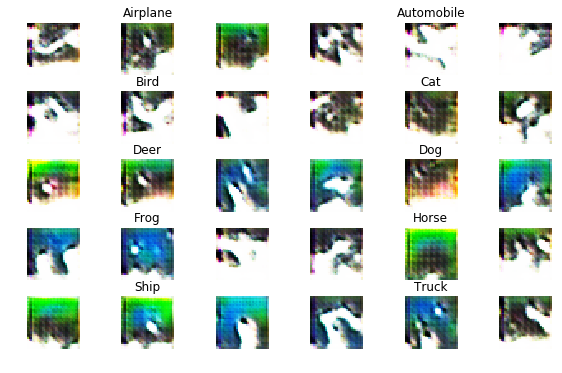

	Epoch: 39, Generator Loss: 0.022547112842222793, Discriminator Loss: [0.00770634 0.        ]


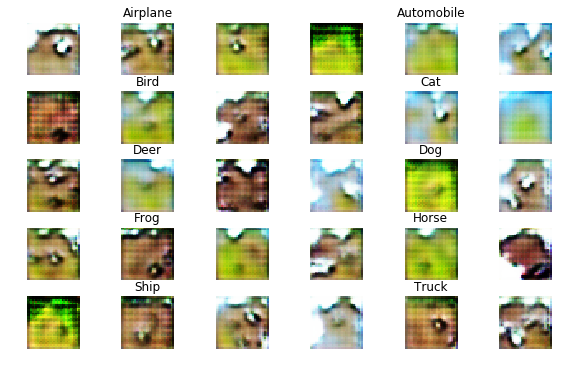

	Epoch: 40, Generator Loss: 0.030228051997330065, Discriminator Loss: [0.00861933 0.        ]


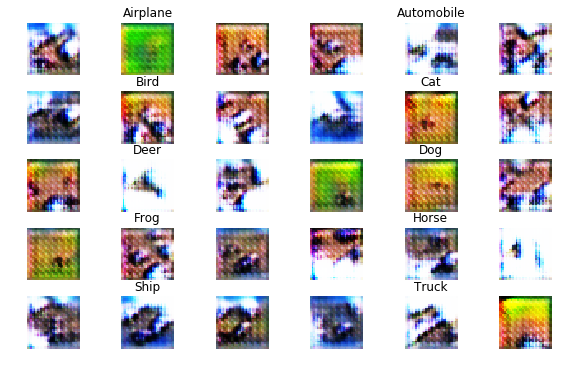

	Epoch: 41, Generator Loss: 0.040940669449892914, Discriminator Loss: [0.00868628 0.        ]


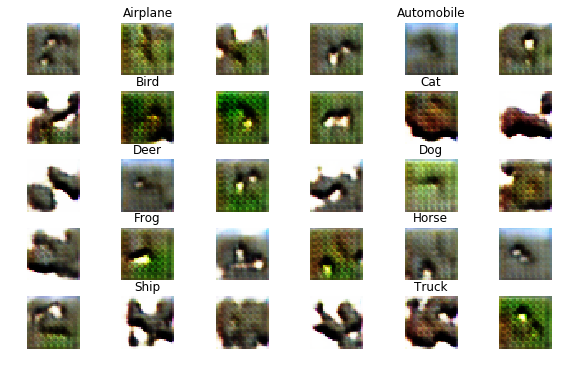

	Epoch: 42, Generator Loss: 0.03510830477929451, Discriminator Loss: [0.00837418 0.        ]


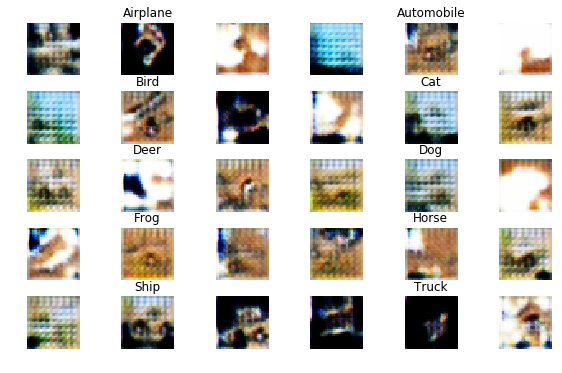

	Epoch: 43, Generator Loss: 0.02569790987748648, Discriminator Loss: [0.00750734 0.        ]


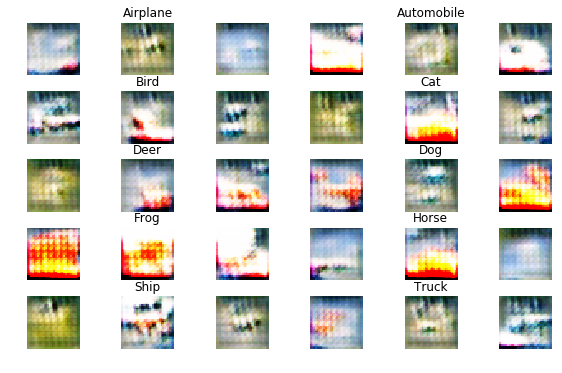

	Epoch: 44, Generator Loss: 0.03203815301920784, Discriminator Loss: [0.00778495 0.        ]


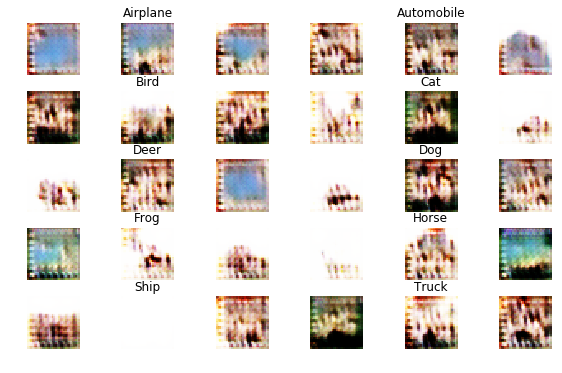

	Epoch: 45, Generator Loss: 0.031429507000498215, Discriminator Loss: [0.00788911 0.        ]


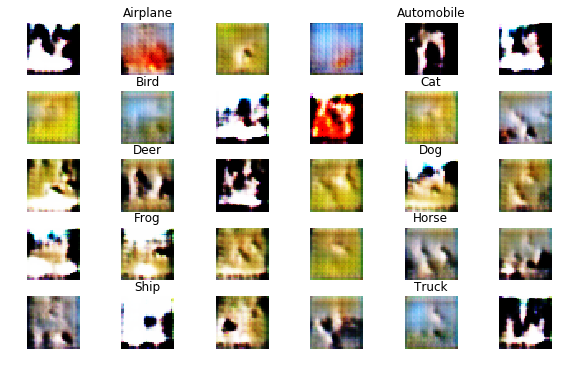

	Epoch: 46, Generator Loss: 0.022164555674325796, Discriminator Loss: [0.00800013 0.        ]


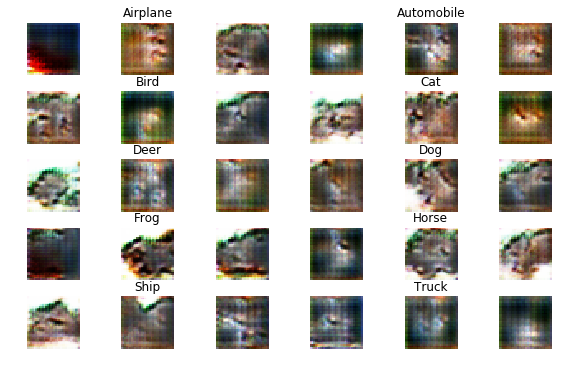

	Epoch: 47, Generator Loss: 0.024540674356354947, Discriminator Loss: [0.00734179 0.        ]


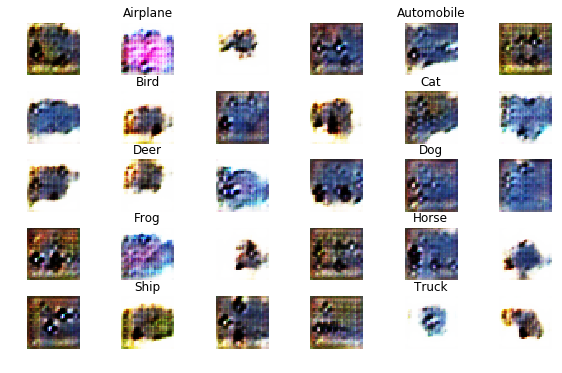

	Epoch: 48, Generator Loss: 0.013202546481591639, Discriminator Loss: [0.00774356 0.        ]


In [ ]:
N_EPOCHS = 300
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
    labels = y_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    # We use same labels for generated images as in the real training batch
    generated_images = generator.predict([noise_data, labels])

    # Train on soft targets (add noise to targets as well)
    noise_prop = 0.05 # Randomly flip 5% of targets
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch([images, labels], true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
    
    # Store a random point for experience replay
    r_idx = np.random.randint(BATCH_SIZE)
    exp_replay.append([generated_images[r_idx], labels[r_idx], gene_labels[r_idx]])
    
    #If we have enough points, do experience replay
    if len(exp_replay) == BATCH_SIZE:
      generated_images = np.array([p[0] for p in exp_replay])
      labels = np.array([p[1] for p in exp_replay])
      gene_labels = np.array([p[2] for p in exp_replay])
      expprep_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
      exp_replay = []
      break
    
    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    g_loss = gan.train_on_batch([noise_data, random_labels, random_labels], np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

  print('\tEpoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_samples("epoch" + str(epoch))


In [ ]:
for classlabel in range(10):
  lbls = one_hot_encode([classlabel] * 9)
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict([noise, lbls])

  fig, axs = plt.subplots(3, 3)
  plt.subplots_adjust(hspace=0.05, wspace=0.05)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      plt.suptitle('Label: ' + str(classlabel))
      count += 1
  plt.show()
  plt.close()  